Importing Dependencies

In [64]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mutual_info_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from pathlib import Path
import pickle

Importing the dataframe

In [17]:
df = pd.read_pickle('../data/processed/processed_df.pkl')

In [19]:
df.shape

(4454, 14)

Checking for missing values

In [18]:
df.isnull().sum()

status        0
seniority     0
home          0
time          0
age           0
marital       0
records       0
job           0
expenses      0
income       34
assets       47
debt         18
amount        0
price         0
dtype: int64

we can look at the distributions of columns with missing values to make a decision

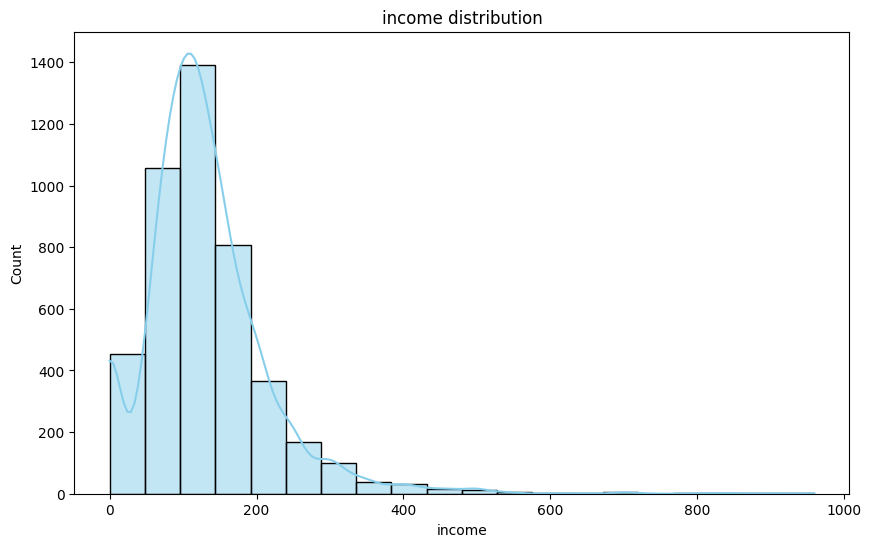

In [29]:
plt.figure(figsize=(10,6))
sns.histplot(df['income'],bins=20,kde=True,color='skyblue')
plt.title('income distribution')
plt.savefig('../plots/income_distribution.png',dpi=300)
plt.show()

Since the distribution is skewed to the left, we can perform mode or median imputation

In [23]:
df['income'] = df['income'].fillna(df['income'].median())

Now let's look at the distribution of assets

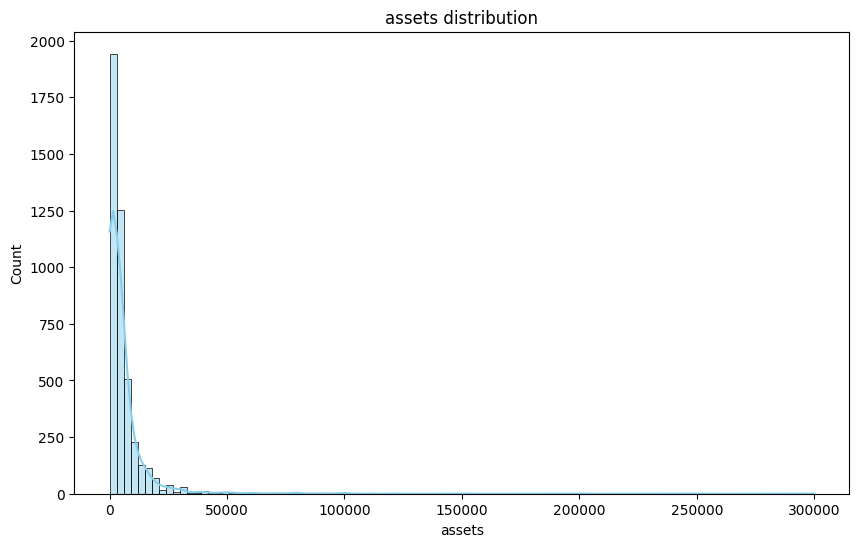

In [28]:
plt.figure(figsize=(10,6))
sns.histplot(df['assets'],bins=100,kde=True,color='skyblue')
plt.title('assets distribution')
plt.savefig('../plots/assets_distribution.png',dpi=300)
plt.show()

Because of its skeweness to the left, we can replace it with the median

In [31]:
df['assets'] = df['assets'].fillna(df['assets'].median())

We do the same with debt column

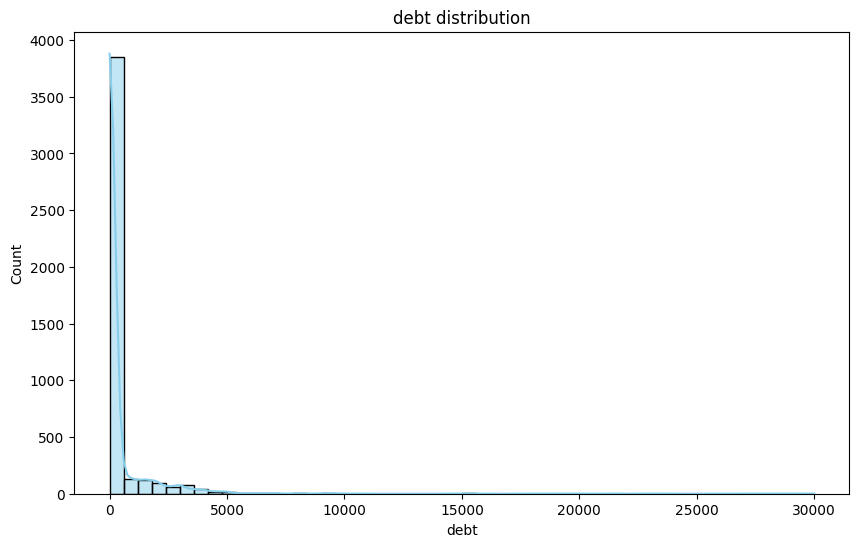

In [34]:
plt.figure(figsize=(10,6))
sns.histplot(df['debt'],bins=50,kde=True,color='skyblue')
plt.title('debt distribution')
plt.savefig('../plots/debt_distribution.png',dpi=300)
plt.show()

In [35]:
df['debt'] = df['debt'].fillna(df['debt'].median())

Now that we dealt with missing values, we can begin our Feature importance analysis

First we will define categorical and numerical features

In [39]:
df.dtypes

status        object
seniority      int64
home          object
time           int64
age            int64
marital       object
records       object
job           object
expenses       int64
income       float64
assets       float64
debt         float64
amount         int64
price          int64
dtype: object

In [43]:
categorical = ['home','marital','records','job']
numerical = ['seniority','time','age','expenses','income','assets','debt','amount','price']

Now we can calculate Mutual information score between categorical variables and the target variable (status)

In [44]:
def calculate_mi(series):
    return mutual_info_score(series,df.status)
df_mi = df[categorical].apply(calculate_mi)
df_mi = df_mi.sort_values(ascending=False).to_frame(name='MI')
df_mi

,MI
records,0.035426
job,0.034318
home,0.025065
marital,0.005863


Conclusions:
* a client who managed to pay back the loan previously is most likely to pay it again
* his job type clearly influences his ability to pay the loan
* then comes his home ownership type, logically a customer renting a home is less likely to pay the loan than a homeowner because of the extra expenses.
* his marital status is less likely to affect his ability to pay back the loan.

Now we can look at numerical variables using correlation coefficient

For this we need to convert the status to binary

In [47]:
df2 = df.copy()
status_values = {
    'ok':1,
    'default':0
}
df2['status'] = df2['status'].map(status_values)

In [48]:
df2.status

0       1
1       1
2       0
3       1
4       1
       ..
4450    0
4451    1
4452    0
4453    1
4454    1
Name: status, Length: 4454, dtype: int64

In [50]:
df2[numerical].corrwith(df2.status).to_frame('correlation')

,correlation
seniority,0.260393
time,-0.100627
age,0.095301
expenses,-0.028855
income,0.208667
assets,0.097067
debt,-0.010011
amount,-0.154549
price,-0.010740


Conclusions:
* seniority (job experience) and income are both positively correlated to status (and highly influences status among other features in term of magnitude), in fact, the higher seniority the higher are monthly earnings and thus the higher ability to pay back the loan.
* assets and age are both positively correlated to status
* price,amount,debt,expenses and time are negatively correlated to status (with time and amount the strongest influencers on status) which is logical

Exporting the dataframe

In [53]:
df.to_pickle('../data/processed/processed_df.pkl')

# Dataset Preparation

Splitting the data to train,val and test

In [55]:
df_train_full,df_test = train_test_split(df,test_size=0.2,random_state=11)
df_train,df_val = train_test_split(df_train_full,test_size=0.25,random_state=11)

In [56]:
len(df_train),len(df_val),len(df_test)

(2672, 891, 891)

Since our objective is to determine if somebody fails to pay back their credit, the positive class id 'default'. This means that y=1 if the client defaulted and 0 otherwise

In [59]:
y_train = (df_train.status == 'default').values
y_val = (df_val.status == 'default').values


Now we'll need to remove 'status' from the dataframes

In [60]:
del df_train['status']
del df_val['status']

And now, the create the X matrix, we need to encode the categorical variables using one-hot encoding technique.

We will be using the dictvectorizer from scikit-learn, so we need to convert the dataframe to a list of dictionaires.

In [61]:
dict_train = df_train.to_dict(orient='records')
dict_val = df_val.to_dict(orient='records')

Each dictionary from this list represents a list. This list now can be used as input to DictVectorizer

In [63]:
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(dict_train)
X_val = dv.transform(dict_val)

As a result, we have feature matrices for both train and vaidation datasets.

Exporting data for model training

In [65]:
df_train_full.to_pickle('../data/processed/df_train_full.pkl')
df_train.to_pickle('../data/processed/df_train.pkl')
df_val.to_pickle('../data/processed/df_val.pkl')
df_test.to_pickle('../data/processed/df_test.pkl')

In [66]:
save_path = Path('../data/processed/')

with open( save_path / 'X_train.pkl','wb') as f:
    pickle.dump(X_train,f)
with open( save_path / 'X_val.pkl','wb') as f:
    pickle.dump(X_val,f)
with open( save_path / 'DictVectorier.pkl','wb') as f:
    pickle.dump(dv,f)
    